In [1]:
pip install rasterio geopandas


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

# Caminho para a imagem TIF
tif_path = "/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF"

# Caminho para o shapefile
shapefile_path = "/home/barcelos/Desktop/AOI/AOI2.shp"

# Leitura do shapefile
aoi = gpd.read_file(shapefile_path)

# Abertura do arquivo TIF
with rasterio.open(tif_path) as src:
    # Reprojetar a geometria do shapefile para o sistema de coordenadas da imagem
    aoi = aoi.to_crs(src.crs)

    # Simplificar a geometria antes de criar a máscara
    simplified_geometry = aoi.geometry.simplify(tolerance=0.01)

    # Criar uma máscara diretamente a partir da geometria simplificada do shapefile
    out_shape = src.shape
    mask_array = geometry_mask(mapping(simplified_geometry), out_shape, src.transform, invert=False)

    # Cortando a imagem com base na máscara
    out_image, out_transform = mask(src, mask_array, crop=True)

    # Atualizar os metadados para a nova imagem cortada
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    # Caminho para a nova imagem cortada
    out_tif_path = "/home/barcelos/Desktop/cropped_B2.tif"

    # Salvar a nova imagem cortada
    with rasterio.open(out_tif_path, "w", **out_meta) as dest:
        dest.write(out_image)


/home/barcelos/.local/lib/python3.10/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape type at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/home/barcelos/.local/lib/python3.10/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape features at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/home/barcelos/.local/lib/python3.10/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape bbox at index 2 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


ValueError: No valid geometry objects found for rasterize

In [14]:
pip install rasterstats


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 KB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import fiona
import rasterio
import rasterio.mask

src_raster_path = "/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF"

shp_file_path = "/home/barcelos/Desktop/AOI/AOI2.shp"

output_raster_path = "/home/barcelos/Desktop/LL14/test.TIF"

with fiona.open(shp_file_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(src_raster_path) as src:

    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})


with rasterio.open(output_raster_path, "w", **out_meta) as dest:
    dest.write(out_image)

ValueError: Input shapes do not overlap raster.

In [4]:
with fiona.open(shp_file_path, "r") as shapefile:
    print(shapefile.crs)

with rasterio.open(src_raster_path) as src:
    print(src.crs)


EPSG:4326
EPSG:32624


In [5]:
with rasterio.open(src_raster_path) as src:
    print(src.bounds)


BoundingBox(left=319785.0, bottom=-2353515.0, right=549015.0, top=-2121285.0)


In [6]:
import fiona
import rasterio
import rasterio.mask

src_raster_path = "/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF"

shp_file_path = "/home/barcelos/Desktop/AOI/AOI2.shp"

output_raster_path = "/home/barcelos/Desktop/LL14/test.TIF"

with fiona.open(shp_file_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(src_raster_path) as src:
    try:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    except ValueError:
        print("No overlap between shapes and raster.")
        # Handle this case (e.g., skip the processing or provide a default output).

if "out_image" in locals():
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)


No overlap between shapes and raster.


In [1]:
import fiona
import rasterio
import rasterio.mask

def mask_raster_with_shapes(src_raster_path, shp_file_path, output_raster_path):
    with fiona.open(shp_file_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(src_raster_path) as src:
        try:
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta
        except ValueError:
            print("nNo overlap between shapes and raster.")
            return  # Exit the function if there's no overlap

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)

# Example usage
src_raster_path = "/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF"
shp_file_path = "/home/barcelos/Desktop/AOI/AOI2.shp"
output_raster_path = "/home/barcelos/Desktop/LL14/test.TIF"

mask_raster_with_shapes(src_raster_path, shp_file_path, output_raster_path)


nNo overlap between shapes and raster.


In [4]:
pip install pycrs

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32704 sha256=c0189486be966f782d9921c42fce690d24f1d5361aa5cb4ad897380e97d9a8f7
  Stored in directory: /home/barcelos/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import fiona
import rasterio
import rasterio.mask
import pycrs
import geopandas


def masked_raster(input_file, raster_file):
    # Create a masked version of the input raster where pixels falling within one of the fields are set to `1` and pixels outside the fields are set to `0`
    
   
    data = rasterio.open(raster_file)
    

    #creating the a bounding box with Shapely
    ## WGS84 coordinates
    minx, miny = 24.60, 60.00
    maxx, maxy = 25.22, 60.35
    bbox = box(minx, miny, maxx, maxy)

    #inserting the bounding box into GeoDataFrame
    geo = geopandas.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

    #Re-project into the same coordinate system as the raster data
    geo = geo.to_crs(crs=data.crs.data)

    #get the coordinates of the geometry in a proper format of rasterio
    def getFeatures(gdf):
      """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
      import json
      return [json.loads(gdf.to_json())['features'][0]['geometry']]

    #Getting the geometry coordinates by using the function
    coordinates = getFeatures(geo)
    # mask to clip the raster with the polygon using the coords variable
    out_img, out_transform = mask(data, shapes=coordinates, crop=True)

    out_img = rasterio.open(raster_file).read()
    return out_img

def reproject_raster(raster_file, dst_crs):
    # Reproject the input raster to the provided CRS
    
    src = rasterio.open(raster_file)
    
    # Parse EPSG code
    epsg_code = int(data.crs.data['init'][5:])

    #copy metadata
    out_meta = raster_file.meta.copy()
    #update the metadata with new dimensions, transform (affine) and CRS 
    out_meta.update({"driver": "GTiff", "height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()})

    #save the clipped raster to disk
    with rasterio.open(out_tif, "w", **out_meta) as dst:
      dst.write(out_img)


    dst = src
    
    return dst

# Run this to validate your function works correctly

assert masked_raster('crops.geojson', 'crops.tif')[0].sum() == 1144636.0, "Sorry wrong answer"
assert str(reproject_raster('crops.tif', 'EPSG:4326').crs) == 'EPSG:4326', "Sorry wrong answer"
print("Congratulations, all is working just fine !!!")

/home/barcelos/.local/lib/python3.10/site-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


TypeError: Cannot convert fill_value nan to dtype uint16

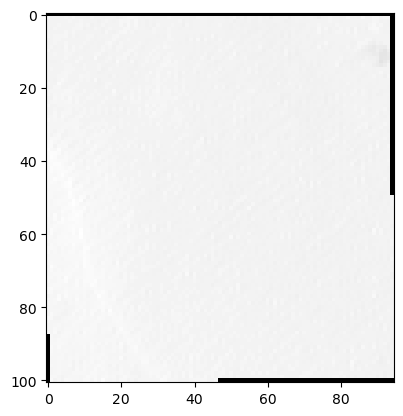

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB2/LL14CUTB2.tif


In [5]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import os

# Substitua 'caminho/para/sua/imagem.tif' pelo caminho real do seu arquivo TIFF
caminho_imagem_b2 = '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF'
caminho_imagem_b3 = '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B3.TIF'
caminho_imagem_b4 = '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B4.TIF'
caminho_imagem_b5 = '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B5.TIF'
# Substitua 'caminho/para/seu/shapefile.shp' pelo caminho real do seu arquivo shapefile
caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

# Abrir a imagem TIFF com rasterio
with rasterio.open(caminho_imagem_b2) as src:
    # Recuperar a geometria da máscara do shapefile
    geometria_mascara_b2 = gdf.geometry.values[0]
    # Converta a geometria para um formato que o rasterio entenda
    geometria_mascara_b2 = [mapping(geometria_mascara_b2)]
    # Recortar a imagem usando a geometria do shapefile como máscara
    imagem_recortada_b2, transformacao_recortada_b2 = mask(src, geometria_mascara_b2, crop=True)
    # Atualizar a transformação da imagem recortada
    profile_b2 = src.profile
    profile_b2['transform'] = transformacao_recortada_b2
# Exibir a imagem recortada
plt.imshow(imagem_recortada_b2[0], cmap='gray')
plt.show()
# Caminho para o diretório de destino
diretorio_destino_b2 = '/home/barcelos/Desktop/LL14/LL14CUTB2/'
# Criar o diretório se não existir
os.makedirs(diretorio_destino_b2, exist_ok=True)
# Salvar a imagem recortada em um novo arquivo TIFF
caminho_destino_b2 = os.path.join(diretorio_destino_b2, 'LL14CUTB2.tif')
with rasterio.open(caminho_destino_b2, 'w', **profile_b2) as dst_b2:
    dst_b2.write(imagem_recortada_b2)
# Exibir mensagem de sucesso
print(f'Imagem recortada salva em: {caminho_destino_b2}')

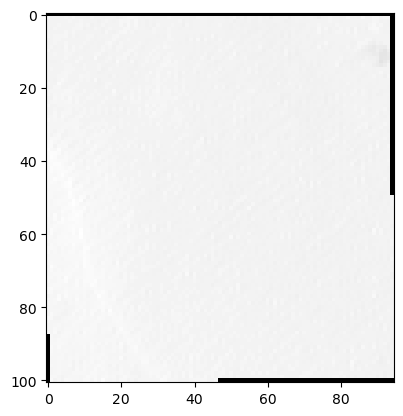

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB2/LL14CUTB2.tif


In [8]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import os

# Substitua 'caminho/para/sua/imagem.tif' pelo caminho real do seu arquivo TIFF
caminho_imagem_b2 = '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF'
caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

# Abrir a imagem TIFF com rasterio
with rasterio.open(caminho_imagem_b2) as src:
    # Recuperar a geometria da máscara do shapefile
    geometria_mascara_b2 = gdf.geometry.values[0]
    # Converta a geometria para um formato que o rasterio entenda
    geometria_mascara_b2 = [mapping(geometria_mascara_b2)]
    # Recortar a imagem usando a geometria do shapefile como máscara
    imagem_recortada_b2, transformacao_recortada_b2 = mask(src, geometria_mascara_b2, crop=True)
    # Atualizar a transformação da imagem recortada
    profile_b2 = src.profile
    profile_b2['transform'] = transformacao_recortada_b2
    profile_b2['height'] = imagem_recortada_b2.shape[1]  # Update height
    profile_b2['width'] = imagem_recortada_b2.shape[2]   # Update width

# Exibir a imagem recortada
plt.imshow(imagem_recortada_b2[0], cmap='gray')
plt.show()

# Caminho para o diretório de destino
diretorio_destino_b2 = '/home/barcelos/Desktop/LL14/LL14CUTB2/'

# Criar o diretório se não existir
os.makedirs(diretorio_destino_b2, exist_ok=True)

# Salvar a imagem recortada em um novo arquivo TIFF
caminho_destino_b2 = os.path.join(diretorio_destino_b2, 'LL14CUTB2.tif')
with rasterio.open(caminho_destino_b2, 'w', **profile_b2) as dst_b2:
    dst_b2.write(imagem_recortada_b2)  # Remove [0], write the whole array

# Exibir mensagem de sucesso
print(f'Imagem recortada salva em: {caminho_destino_b2}')

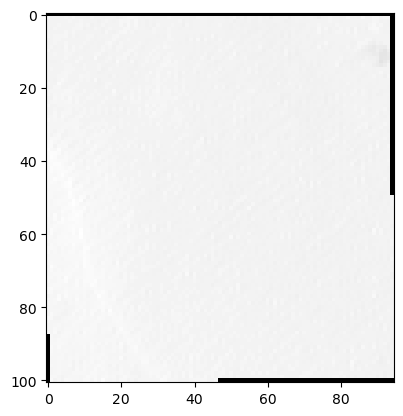

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB2/LL14CUTB2.tif


In [10]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import os

# Substitua 'caminho/para/sua/imagem.tif' pelo caminho real do seu arquivo TIFF
caminho_imagem_b2 = '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF'
caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

# Abrir a imagem TIFF com rasterio
with rasterio.open(caminho_imagem_b2) as src:
    # Recuperar a geometria da máscara do shapefile
    geometria_mascara_b2 = gdf.geometry.values[0]
    # Converta a geometria para um formato que o rasterio entenda
    geometria_mascara_b2 = [mapping(geometria_mascara_b2)]

    # Recortar a imagem usando a geometria do shapefile como máscara com resampling 'nearest'
    imagem_recortada_b2, transformacao_recortada_b2 = mask(src, geometria_mascara_b2, crop=True)
    
    # Atualizar a transformação da imagem recortada com resampling 'nearest'
    transformacao_recortada_b2 = rasterio.Affine.scale(src.transform.a / transformacao_recortada_b2.a,
                                                       src.transform.e / transformacao_recortada_b2.e) * transformacao_recortada_b2
    
    # Atualizar a transformação da imagem recortada
    profile_b2 = src.profile
    profile_b2['transform'] = transformacao_recortada_b2
    profile_b2['height'] = imagem_recortada_b2.shape[1]  # Update height
    profile_b2['width'] = imagem_recortada_b2.shape[2]   # Update width

# Exibir a imagem recortada
plt.imshow(imagem_recortada_b2[0], cmap='gray')
plt.show()

# Caminho para o diretório de destino
diretorio_destino_b2 = '/home/barcelos/Desktop/LL14/LL14CUTB2/'

# Criar o diretório se não existir
os.makedirs(diretorio_destino_b2, exist_ok=True)

# Salvar a imagem recortada em um novo arquivo TIFF
caminho_destino_b2 = os.path.join(diretorio_destino_b2, 'LL14CUTB2.tif')
with rasterio.open(caminho_destino_b2, 'w', **profile_b2) as dst_b2:
    dst_b2.write(imagem_recortada_b2)

# Exibir mensagem de sucesso
print(f'Imagem recortada salva em: {caminho_destino_b2}')


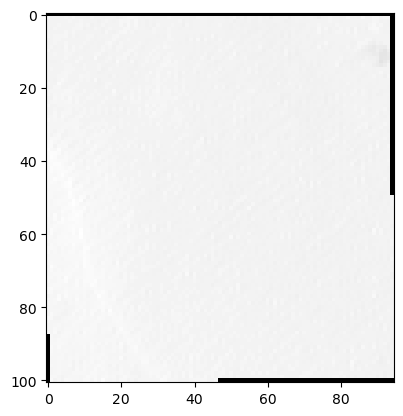

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2_CUT.tif


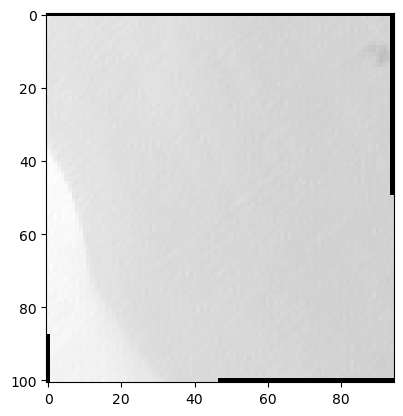

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B3_CUT.tif


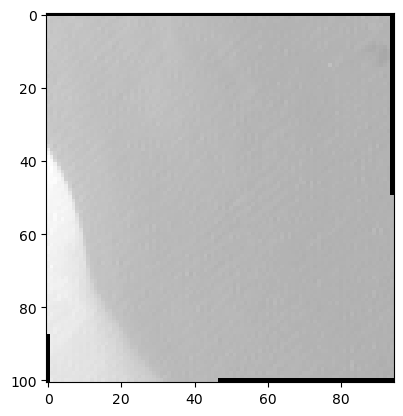

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B4_CUT.tif


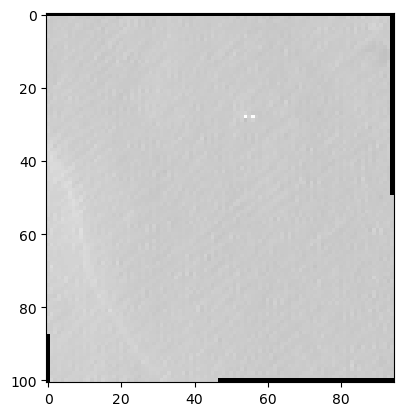

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B5_CUT.tif


In [11]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import os

# Lista de caminhos para as suas imagens TIFF
caminhos_imagens = [
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B3.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B4.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B5.TIF'
]

caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

for caminho_imagem in caminhos_imagens:
    # Abrir a imagem TIFF com rasterio
    with rasterio.open(caminho_imagem) as src:
        # Recuperar a geometria da máscara do shapefile
        geometria_mascara = gdf.geometry.values[0]
        # Converta a geometria para um formato que o rasterio entenda
        geometria_mascara = [mapping(geometria_mascara)]

        # Recortar a imagem usando a geometria do shapefile como máscara
        imagem_recortada, transformacao_recortada = mask(src, geometria_mascara, crop=True)

        # Atualizar a transformação da imagem recortada
        profile = src.profile
        profile['transform'] = transformacao_recortada
        profile['height'] = imagem_recortada.shape[1]  # Update height
        profile['width'] = imagem_recortada.shape[2]   # Update width

    # Exibir a imagem recortada
    plt.imshow(imagem_recortada[0], cmap='gray')
    plt.show()

    # Caminho para o diretório de destino
    diretorio_destino = '/home/barcelos/Desktop/LL14/'

    # Criar o diretório se não existir
    os.makedirs(diretorio_destino, exist_ok=True)

    # Obter o nome do arquivo da imagem original
    nome_arquivo = os.path.basename(caminho_imagem)
    
    # Salvar a imagem recortada em um novo arquivo TIFF
    caminho_destino = os.path.join(diretorio_destino, f'{nome_arquivo[:-4]}_CUT.tif')
    with rasterio.open(caminho_destino, 'w', **profile) as dst:
        dst.write(imagem_recortada)

    # Exibir mensagem de sucesso
    print(f'Imagem recortada salva em: {caminho_destino}')

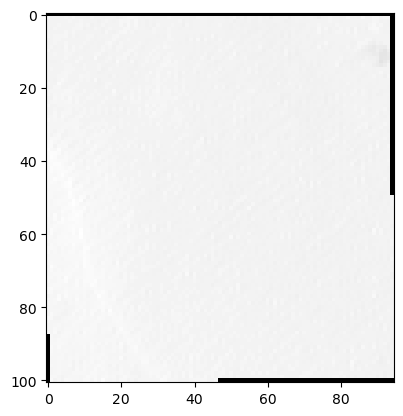

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B2_CUT.tif


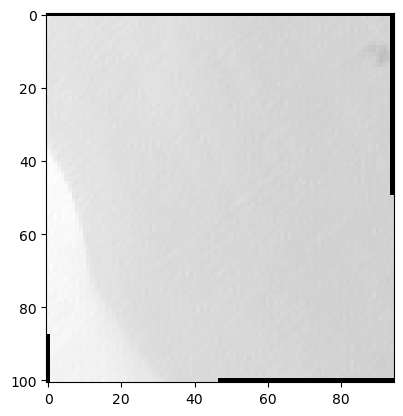

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B3_CUT.tif


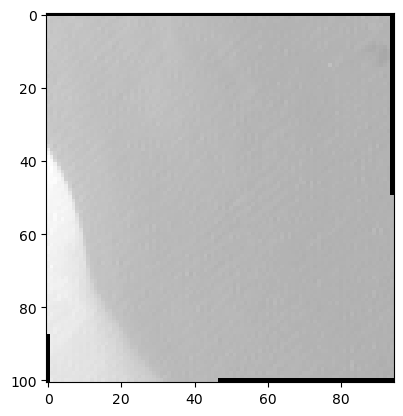

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B4_CUT.tif


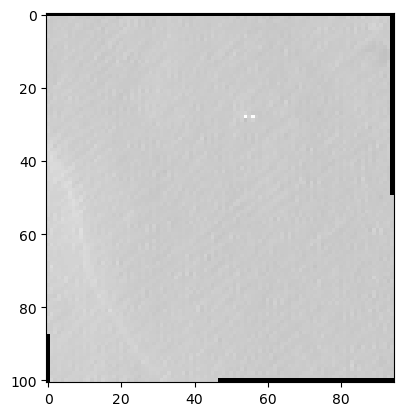

Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B5_CUT.tif


In [12]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib import pyplot as plt
import os

# Lista de caminhos para as suas imagens TIFF
caminhos_imagens = [
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B3.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B4.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B5.TIF'
]

caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

# Caminho para o diretório de destino pai
diretorio_destino_pai = '/home/barcelos/Desktop/LL14/'

for caminho_imagem in caminhos_imagens:
    # Abrir a imagem TIFF com rasterio
    with rasterio.open(caminho_imagem) as src:
        # Recuperar a geometria da máscara do shapefile
        geometria_mascara = gdf.geometry.values[0]
        # Converta a geometria para um formato que o rasterio entenda
        geometria_mascara = [mapping(geometria_mascara)]

        # Recortar a imagem usando a geometria do shapefile como máscara
        imagem_recortada, transformacao_recortada = mask(src, geometria_mascara, crop=True)

        # Atualizar a transformação da imagem recortada
        profile = src.profile
        profile['transform'] = transformacao_recortada
        profile['height'] = imagem_recortada.shape[1]  # Update height
        profile['width'] = imagem_recortada.shape[2]   # Update width

    # Exibir a imagem recortada
    plt.imshow(imagem_recortada[0], cmap='gray')
    plt.show()

    # Caminho para o diretório de destino específico para cada banda
    nome_banda = os.path.basename(caminho_imagem).split('_')[-1][0]
    diretorio_destino = os.path.join(diretorio_destino_pai, f'LL14CUTB{nome_banda}')

    # Criar o diretório se não existir
    os.makedirs(diretorio_destino, exist_ok=True)

    # Obter o nome do arquivo da imagem original
    nome_arquivo = os.path.basename(caminho_imagem)

    # Salvar a imagem recortada em um novo arquivo TIFF
    caminho_destino = os.path.join(diretorio_destino, f'{nome_arquivo[:-4]}_CUT.tif')
    with rasterio.open(caminho_destino, 'w', **profile) as dst:
        dst.write(imagem_recortada)

    # Exibir mensagem de sucesso
    print(f'Imagem recortada salva em: {caminho_destino}')


In [15]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import os

# Lista de caminhos para as suas imagens TIFF
caminhos_imagens = [
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B3.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B4.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B5.TIF'
]

caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

# Caminho para o diretório de destino pai
diretorio_destino_pai = '/home/barcelos/Desktop/LL14/'

for caminho_imagem in caminhos_imagens:
    # Abrir a imagem TIFF com rasterio
    with rasterio.open(caminho_imagem) as src:
        # Recuperar a geometria da máscara do shapefile
        geometria_mascara = gdf.geometry.values[0]
        # Converta a geometria para um formato que o rasterio entenda
        geometria_mascara = [mapping(geometria_mascara)]

        # Recortar a imagem usando a geometria do shapefile como máscara
        imagem_recortada, transformacao_recortada = mask(src, geometria_mascara, crop=True)

        # Atualizar a transformação da imagem recortada
        profile = src.profile
        profile['transform'] = transformacao_recortada
        profile['height'] = imagem_recortada.shape[1]  # Update height
        profile['width'] = imagem_recortada.shape[2]   # Update width

    # Obter o nome da banda a partir do caminho da imagem
    nome_banda = os.path.basename(caminho_imagem).split('_')[-1][0]

    # Caminho para o diretório de destino específico para cada banda
    diretorio_destino = os.path.join(diretorio_destino_pai, f'LL14CUTB{nome_banda}')

    # Criar o diretório se não existir
    os.makedirs(diretorio_destino, exist_ok=True)

    # Obter o nome do arquivo da imagem original
    nome_arquivo = os.path.basename(caminho_imagem)

    # Salvar a imagem recortada em um novo arquivo TIFF
    caminho_destino = os.path.join(diretorio_destino, f'{nome_arquivo[:-4]}_CUT.tif')
    with rasterio.open(caminho_destino, 'w', **profile) as dst:
        dst.write(imagem_recortada)

    # Exibir mensagem de sucesso
    print(f'Imagem recortada salva em: {caminho_destino}')


Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B2_CUT.tif
Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B3_CUT.tif
Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B4_CUT.tif
Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTBB/LC08_L1TP_215074_20141229_20200910_02_T1_B5_CUT.tif


In [16]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import os

# Lista de caminhos para as suas imagens TIFF
caminhos_imagens = [
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B2.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B3.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B4.TIF',
    '/home/barcelos/Desktop/LL14/LC08_L1TP_215074_20141229_20200910_02_T1_B5.TIF'
]

caminho_shapefile = '/home/barcelos/Desktop/AOI/AOI2.shp'

# Abrir o shapefile com geopandas
gdf = gpd.read_file(caminho_shapefile)

# Reprojetar a geometria do shapefile para o CRS da imagem raster (EPSG:32624)
gdf = gdf.to_crs(epsg=32624)

# Caminho para o diretório de destino pai
diretorio_destino_pai = '/home/barcelos/Desktop/LL14/'

for caminho_imagem in caminhos_imagens:
    # Abrir a imagem TIFF com rasterio
    with rasterio.open(caminho_imagem) as src:
        # Recuperar a geometria da máscara do shapefile
        geometria_mascara = gdf.geometry.values[0]
        # Converta a geometria para um formato que o rasterio entenda
        geometria_mascara = [mapping(geometria_mascara)]

        # Recortar a imagem usando a geometria do shapefile como máscara
        imagem_recortada, transformacao_recortada = mask(src, geometria_mascara, crop=True)

        # Atualizar a transformação da imagem recortada
        profile = src.profile
        profile['transform'] = transformacao_recortada
        profile['height'] = imagem_recortada.shape[1]  # Update height
        profile['width'] = imagem_recortada.shape[2]   # Update width

    # Obter o nome da banda a partir do caminho da imagem
    nome_banda = os.path.basename(caminho_imagem).split('_')[-1][1]

    # Caminho para o diretório de destino específico para cada banda
    diretorio_destino = os.path.join(diretorio_destino_pai, f'LL14CUTB{nome_banda}')

    # Criar o diretório se não existir
    os.makedirs(diretorio_destino, exist_ok=True)

    # Obter o nome do arquivo da imagem original
    nome_arquivo = os.path.basename(caminho_imagem)

    # Salvar a imagem recortada em um novo arquivo TIFF
    caminho_destino = os.path.join(diretorio_destino, f'{nome_arquivo[:-4]}_CUT.tif')
    with rasterio.open(caminho_destino, 'w', **profile) as dst:
        dst.write(imagem_recortada)

    # Exibir mensagem de sucesso
    print(f'Imagem recortada salva em: {caminho_destino}')


Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB2/LC08_L1TP_215074_20141229_20200910_02_T1_B2_CUT.tif
Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB3/LC08_L1TP_215074_20141229_20200910_02_T1_B3_CUT.tif
Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB4/LC08_L1TP_215074_20141229_20200910_02_T1_B4_CUT.tif
Imagem recortada salva em: /home/barcelos/Desktop/LL14/LL14CUTB5/LC08_L1TP_215074_20141229_20200910_02_T1_B5_CUT.tif
